This Notebook gives an introduction for dealing with multiple annotators using `scikit-activeml`.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from skactiveml.classifier import PWC
from skactiveml.pool import UncertaintySampling
from skactiveml.pool.multi import IEThresh
from skactiveml.pool.multi._wrapper import MultiAnnotWrapper
from skactiveml.visualization.multi.multi_annot_visualisation import show_current_state, plot_data_set
from skactiveml.utils import is_unlabeled, MISSING_LABEL
import warnings
warnings.filterwarnings("ignore")

Suppose we have the following problem. We have 100 samples having 2 features
belonging to either one of two classes. To generate the example problem, we
use the `make_classification` function by sklearn.

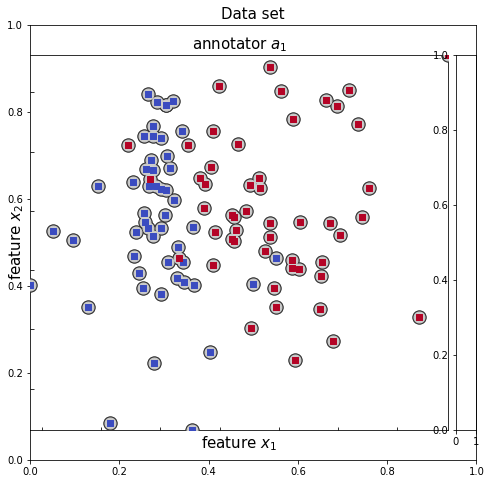

In [31]:
n_samples = 100
X, y_true = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, random_state=0)
plot_data_set(X, y_true, y_true.reshape(-1, 1), title='Data set', fig_size=(8, 8),
              plot_legend=False)
plt.show()

Further, suppose we have 5 annotators to label the samples. The annotators have
different accuracies for labeling the samples.

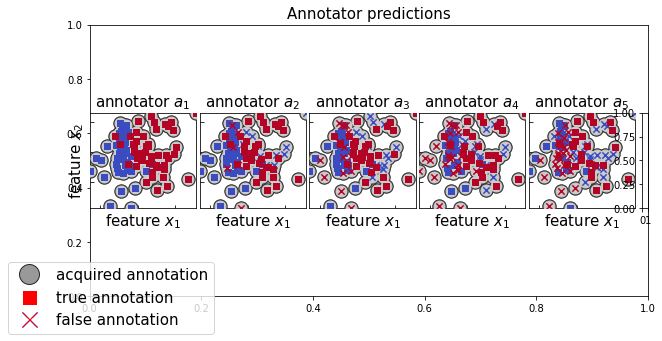

In [32]:
rng = np.random.default_rng(seed=0)
n_annotators = 5
y_annot = np.zeros(shape=(n_samples, n_annotators), dtype=int)
for i, p in enumerate(np.linspace(0.0, 0.5, num=n_annotators)):
    y_noise = rng.binomial(1, p, n_samples)
    y_annot[:, i] = y_noise ^ y_true

plot_data_set(X, y_true, y_annot, title='Annotator predictions', fig_size=(10, 5),
              legend_dict={'loc': 'lower left'})
plt.show()

We want to label these samples using a Parzen window classifier. We query the
samples using uncertainty sampling, and the annotators at random using the
`MultiAnnotWrapper`.
To archive this, we first pass the Parzen window classifier as an argument to
the single query strategy uncertainty sampling. Then we pass the single query
strategy as an argument to the wrapper, also specifying the number of annotators.


In [33]:
clf = PWC(classes=np.unique(y_true))
sa_qs = UncertaintySampling(random_state=0)
ma_qs = MultiAnnotWrapper(sa_qs, random_state=0, n_annotators=n_annotators)

We loop through the process of querying samples and annotators over a total of
20 cycles. Each iteration we query three annotators for one sample, setting the
batch size and the number of annotators per sample to three.
We set the candidate annotators for each sample to be those, who have not already
labeled the given sample. Further we fit our classifier with the queried labels.
The results are displayed after the second, the tenth and the 20th cycle.
The assigned utilities of the query strategy for labeling a sample annotator
pair are displayed by the saturation of the green color in the plot.


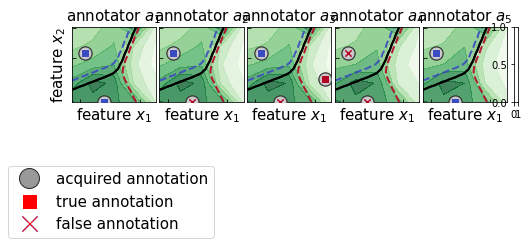

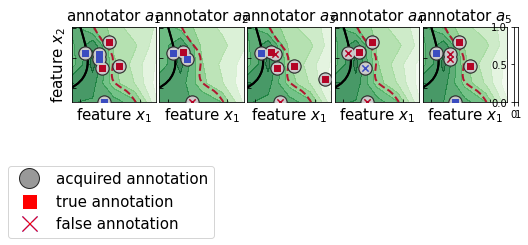

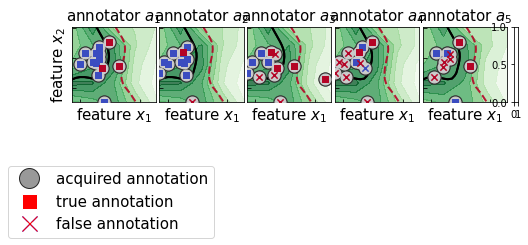

In [34]:
# function to be able to index via an array of indices
idx = lambda A: (A[:, 0], A[:, 1])

n_cycle = 20

# the already observed labels for each sample and annotator
y = np.full(shape=(n_samples, n_annotators), fill_value=MISSING_LABEL)

for c in range(n_cycle):
    A_cand = is_unlabeled(y)

    # the needed query parameters for the wrapped singe annotator query strategy
    query_params_dict = {'clf': clf, 'X': X, 'y':y}

    query_idx = ma_qs.query(X_cand=X, A_cand=A_cand, batch_size=3,
                            n_annotators_per_sample=3,
                            query_params_dict=query_params_dict)

    y[idx(query_idx)] = y_annot[idx(query_idx)]
    clf.fit(X, y)
    if c in [3, 9, 19]:
        ma_qs_arg_dict = {'query_params_dict': query_params_dict}
        show_current_state(X, y, y_true, ma_qs, clf, ma_qs_arg_dict=ma_qs_arg_dict)